In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np


# Calculating pi using Monte Carlo methods
## Relevant formulas

- square area: $s = (2 r)^2$
- circle area: $c = \pi r^2$
- $c/s = (\pi r^2) / (4 r^2) = \pi / 4$
- $\pi = 4 * c/s$

## Image to visualize the concept

![Darts](https://raw.githubusercontent.com/coderefinery/jupyter/main/example/darts.svg)

In [11]:
# importing modules that we will need
%reset -f
import random
import matplotlib.pyplot as plt

In [ ]:
# test change

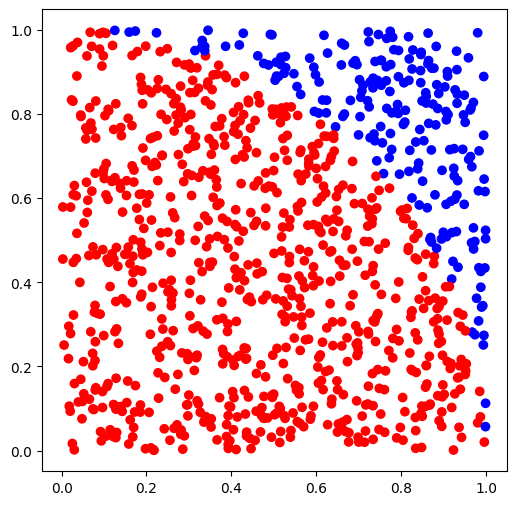

In [13]:
# initializing the number of "throws"
num_points = 1000
# here we "throw darts" and count the number of hits

points = []
hits = 0
for _ in range(num_points):
    x, y = random.random(), random.random()
    if x*x + y*y < 1.0:
        hits += 1
        points.append((x, y, "red"))
    else:
        points.append((x, y, "blue"))
# unzip points into 3 lists
x, y, colors = zip(*points)

# define figure dimensions
fig, ax = plt.subplots()
fig.set_size_inches(6.0, 6.0)

# plot results
ax.scatter(x, y, c=colors)

In [ ]:
# add something new

In [2]:
# load the fetch_california_housing data
from sklearn.datasets import fetch_california_housing

# Load the data
housing = fetch_california_housing()
data, target = housing.data, housing.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
# print(X_train.shape) 16512 rows



# Standardize the data (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [59]:
print(X_train.shape)
print(X_train_encoded.shape)
print(type(layers))
print(type(input_layer))

(16512, 8)
(16512, 32)
<class 'module'>
<class 'keras.src.engine.keras_tensor.KerasTensor'>


In [ ]:
# Autoencoders for feature learning
# Define autoencoder
input_shape = X_train.shape[1]
encoding_dim = 32

input_layer = layers.Input(shape=(input_shape,))
encoder = layers.Dense(encoding_dim, activation='relu')(input_layer)
decoder = layers.Dense(input_shape, activation='sigmoid')(encoder)

autoencoder = models.Model(input_layer, decoder)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Use encoder part to get compressed features
encoder_model = models.Model(input_layer, encoder)
X_train_encoded = encoder_model.predict(X_train)
X_test_encoded = encoder_model.predict(X_test)

# Define and train a simple neural network on encoded features
nn_model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(encoding_dim,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
nn_history = nn_model.fit(X_train_encoded, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)
nn_mse, nn_mae = nn_model.evaluate(X_test_encoded, y_test, verbose=0)
print(f'Neural Network Test MSE: {nn_mse}, MAE: {nn_mae}')

In [64]:
print(type(nn_model))

<class 'keras.src.engine.sequential.Sequential'>


In [63]:
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = models.Sequential()
    model.add(layers.Dense(hp.Int('units', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train.shape[1],)))
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(layers.Dense(hp.Int(f'units_{i}', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

tuner = RandomSearch(build_model, objective='val_mae', max_trials=10, executions_per_trial=2, directory='my_dir', project_name='housing')
tuner.search(X_train, y_train, epochs=20, validation_split=0.2)
best_model = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 00m 51s]
val_mae: 0.35665611922740936

Best val_mae So Far: 0.354525089263916
Total elapsed time: 00h 09m 55s


In [65]:
# Evaluate the best model
mse, mae = best_model.evaluate(X_test, y_test)
print(f'Best Model - MSE: {mse}, MAE: {mae}')

129/129 [==============================] - 0s 2ms/step - loss: 0.2777 - mae: 0.3496
Best Model - MSE: 0.2777145206928253, MAE: 0.3495747148990631


In [33]:
# Build the Random Forest
# So far the best approach
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the random forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred_rf = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
print(f'Random Forest - MSE: {rf_mse}, MAE: {rf_mae}')


Random Forest - MSE: 0.255169737347244, MAE: 0.3274252027374032


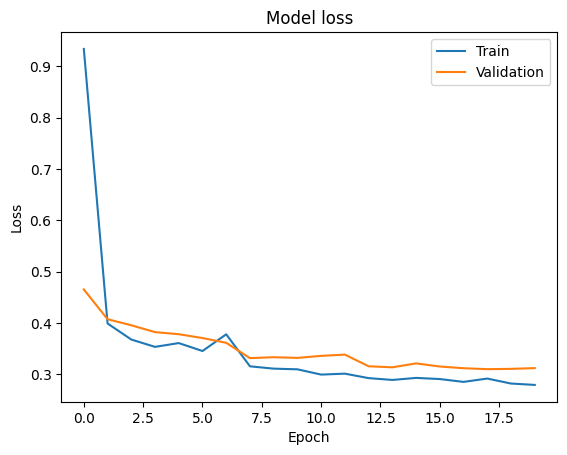

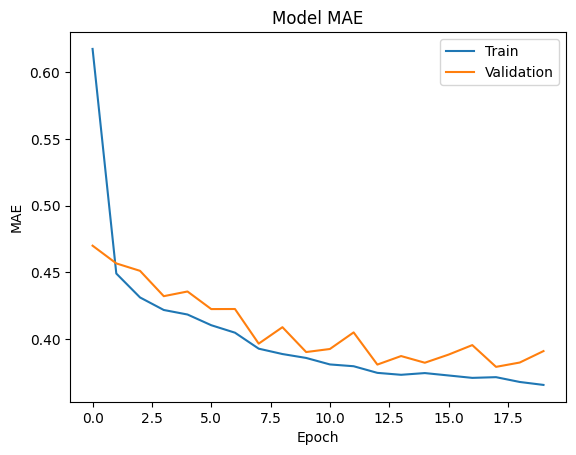

In [28]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation MAE values
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [25]:
print(X_train.shape[0])
print(y_train.shape)
print(type(y_train))
print(y_train[:5])
print(X_test[:5])

16512
(16512,)
<class 'numpy.ndarray'>
[1.03  3.821 1.726 0.934 0.965]
[[-1.15508475 -0.28632369 -0.52068576 -0.17174603 -0.03030109  0.06740798
   0.1951      0.28534728]
 [-0.70865905  0.11043502 -0.16581537  0.22347203  0.12185077 -0.03602975
  -0.23549054  0.06097472]
 [-0.21040155  1.85617335 -0.61076476  0.20589202 -0.10241931 -0.14998876
   1.00947776 -1.42487026]
 [ 0.97511311 -0.92113763  0.3051148  -0.17655235  0.24497944  0.03001135
  -0.63799909  0.42994293]
 [-0.08179356  0.42784199  0.02419284 -0.15846523 -0.31965346 -0.05297076
   0.45719859 -1.17058135]]


In [16]:
print(type(housing))

# List all the attributes of the bunch object
print(housing.keys())
# print(housing.DESCR)

print(housing.data.shape)
print(type(data))
print(data[:5])
print(type(target))
print(target[:5])

<class 'sklearn.utils._bunch.Bunch'>
dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])
(20640, 8)
<class 'numpy.ndarray'>
[[ 8.32520000e+00  4.10000000e+01  6.98412698e+00  1.02380952e+00
   3.22000000e+02  2.55555556e+00  3.78800000e+01 -1.22230000e+02]
 [ 8.30140000e+00  2.10000000e+01  6.23813708e+00  9.71880492e-01
   2.40100000e+03  2.10984183e+00  3.78600000e+01 -1.22220000e+02]
 [ 7.25740000e+00  5.20000000e+01  8.28813559e+00  1.07344633e+00
   4.96000000e+02  2.80225989e+00  3.78500000e+01 -1.22240000e+02]
 [ 5.64310000e+00  5.20000000e+01  5.81735160e+00  1.07305936e+00
   5.58000000e+02  2.54794521e+00  3.78500000e+01 -1.22250000e+02]
 [ 3.84620000e+00  5.20000000e+01  6.28185328e+00  1.08108108e+00
   5.65000000e+02  2.18146718e+00  3.78500000e+01 -1.22250000e+02]]
<class 'numpy.ndarray'>
[4.526 3.585 3.521 3.413 3.422]


In [10]:
a,b=1,2
print(a)
print(b)

1
2
